# Objašnjiva umjetna inteligencija (XAI)
## Heart Disease

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from ucimlrepo import fetch_ucirepo

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pydl85 import DL85Classifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from lime.lime_tabular import LimeTabularExplainer
import shap

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#### Pregled skupa podataka
##### Baza podataka o srčanim bolestima

Radi se o multivarijatnoj bazi podataka iz područja zdravlja i medicine, koja je namijenjena klasifikacijskim zadacima. Značajke unutar baze su različitih tipova, uključujući kategorijske, cijelobrojne i realne vrijednosti. Baza sadrži ukupno 303 instance s 76 atributa, no svi objavljeni eksperimenti koriste podskup od 14 atributa (13 značajki i klasifikacija).


U istraživanjima strojnog učenja najčešće se koristi Cleveland baza podataka, a cilj (oznaka "goal") odnosi se na prepoznavanje prisutnosti srčanih bolesti kod pacijenta. Vrijednost cilja može biti cijeli broj od 0 (odsutnost bolesti) do 4 (prisutnost bolesti u različitim stupnjevima). Eksperimenti s Cleveland bazom uglavnom se fokusiraju na razlikovanje između prisutnosti (vrijednosti 1, 2, 3, 4) i odsutnosti (vrijednost 0) bolesti.

In [102]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

print(heart_disease.variables)


        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [103]:
print(X)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  
0        3  0.0   6.0  
1        2  3.0   3.0  
2        2  2.0

In [104]:
print(y)

     num
0      0
1      2
2      1
3      0
4      0
..   ...
298    1
299    2
300    3
301    1
302    0

[303 rows x 1 columns]


In [105]:
print('Missing values:\n' + str(np.isnan(X).sum()))
print('\nDuplicated: ' + str(X.duplicated().sum()))

Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Duplicated: 0


In [106]:
valid_rows = ~np.isnan(X).any(axis=1)

X = X[valid_rows]
y = y[valid_rows]

print(X.shape, y.shape)
print('Missing values:\n' + str(np.isnan(X).sum()))

(297, 13) (297, 1)
Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
dtype: int64


In [107]:
fig = px.histogram(data_frame=X, x='age', color= 'sex')
fig.show()

# 1-male, 0-female
X['sex'].value_counts()


sex
1    201
0     96
Name: count, dtype: int64

In [108]:
fig = px.histogram(data_frame=y)
fig.show()

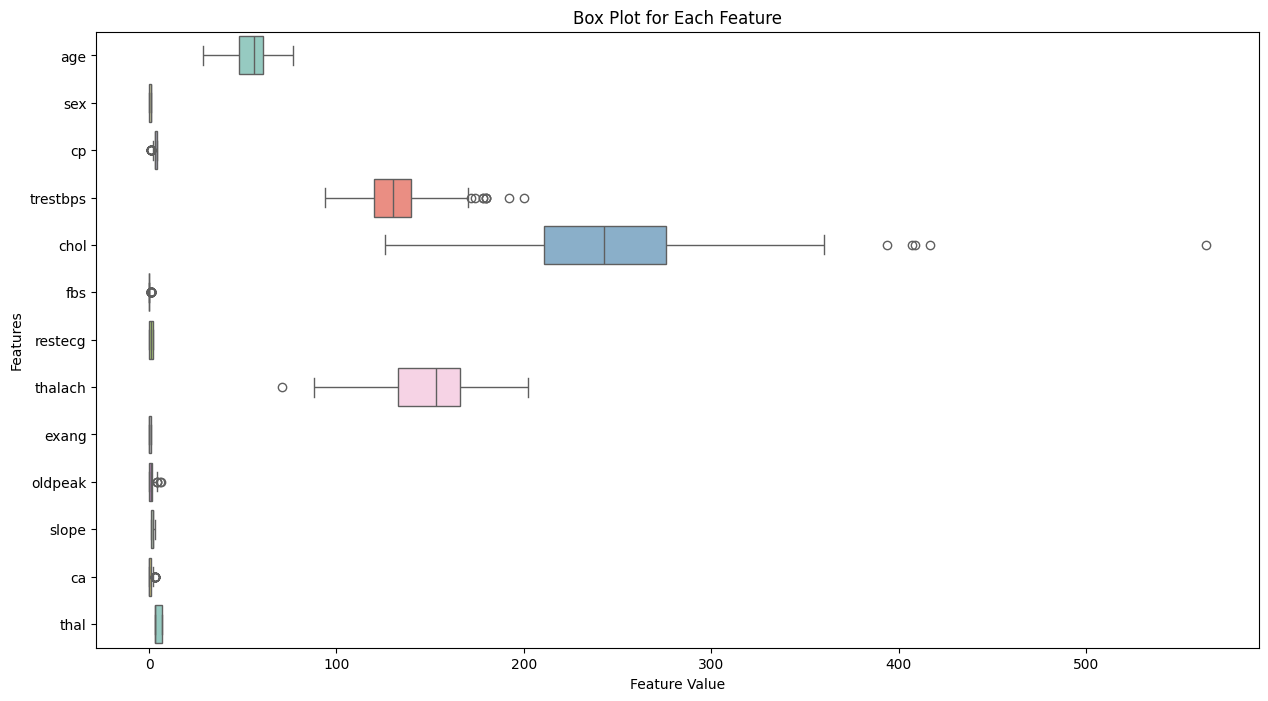

In [109]:
def box_plot(X):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=X, orient="h", palette="Set3")
    plt.title("Box Plot for Each Feature")
    plt.xlabel("Feature Value")
    plt.ylabel("Features")
    plt.show()
box_plot(X)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=0.25, random_state=42)

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_bin = encoder.fit_transform(X_train)
X_test_bin = encoder.transform(X_test)

### Stablo oduke

In [111]:
dl85 = DL85Classifier(max_depth=3, min_sup=5)
dl85.fit(X_train_bin.toarray(), y_train)

y_pred_dl85 = dl85.predict(X_test_bin.toarray())
print(y_pred_dl85)

[0, 2, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 3, 0, 0, 3, 0, 3, 0, 1, 0, 1, 3, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 2, 3, 3, 0, 1]


In [112]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)
print(y_pred_dt)

[0 1 0 3 0 2 0 2 0 0 0 0 0 1 0 0 0 0 3 0 2 2 0 0 3 0 3 0 0 0 0 0 3 0 0 0 0
 0 2 1 0 3 3 3 0 0 0 0 2 0 0 2 0 0 1 3 0 0 2 0 0 0 2 0 0 0 0 0 3 1 1 3 2 0
 2]


#### Vizualizacija

|--- feature_11 <= 0.50
|   |--- feature_12 <= 6.50
|   |   |--- feature_9 <= 2.70
|   |   |   |--- class: 0
|   |   |--- feature_9 >  2.70
|   |   |   |--- class: 0
|   |--- feature_12 >  6.50
|   |   |--- feature_7 <= 129.00
|   |   |   |--- class: 3
|   |   |--- feature_7 >  129.00
|   |   |   |--- class: 0
|--- feature_11 >  0.50
|   |--- feature_9 <= 0.90
|   |   |--- feature_2 <= 3.50
|   |   |   |--- class: 0
|   |   |--- feature_2 >  3.50
|   |   |   |--- class: 1
|   |--- feature_9 >  0.90
|   |   |--- feature_7 <= 139.50
|   |   |   |--- class: 3
|   |   |--- feature_7 >  139.50
|   |   |   |--- class: 2



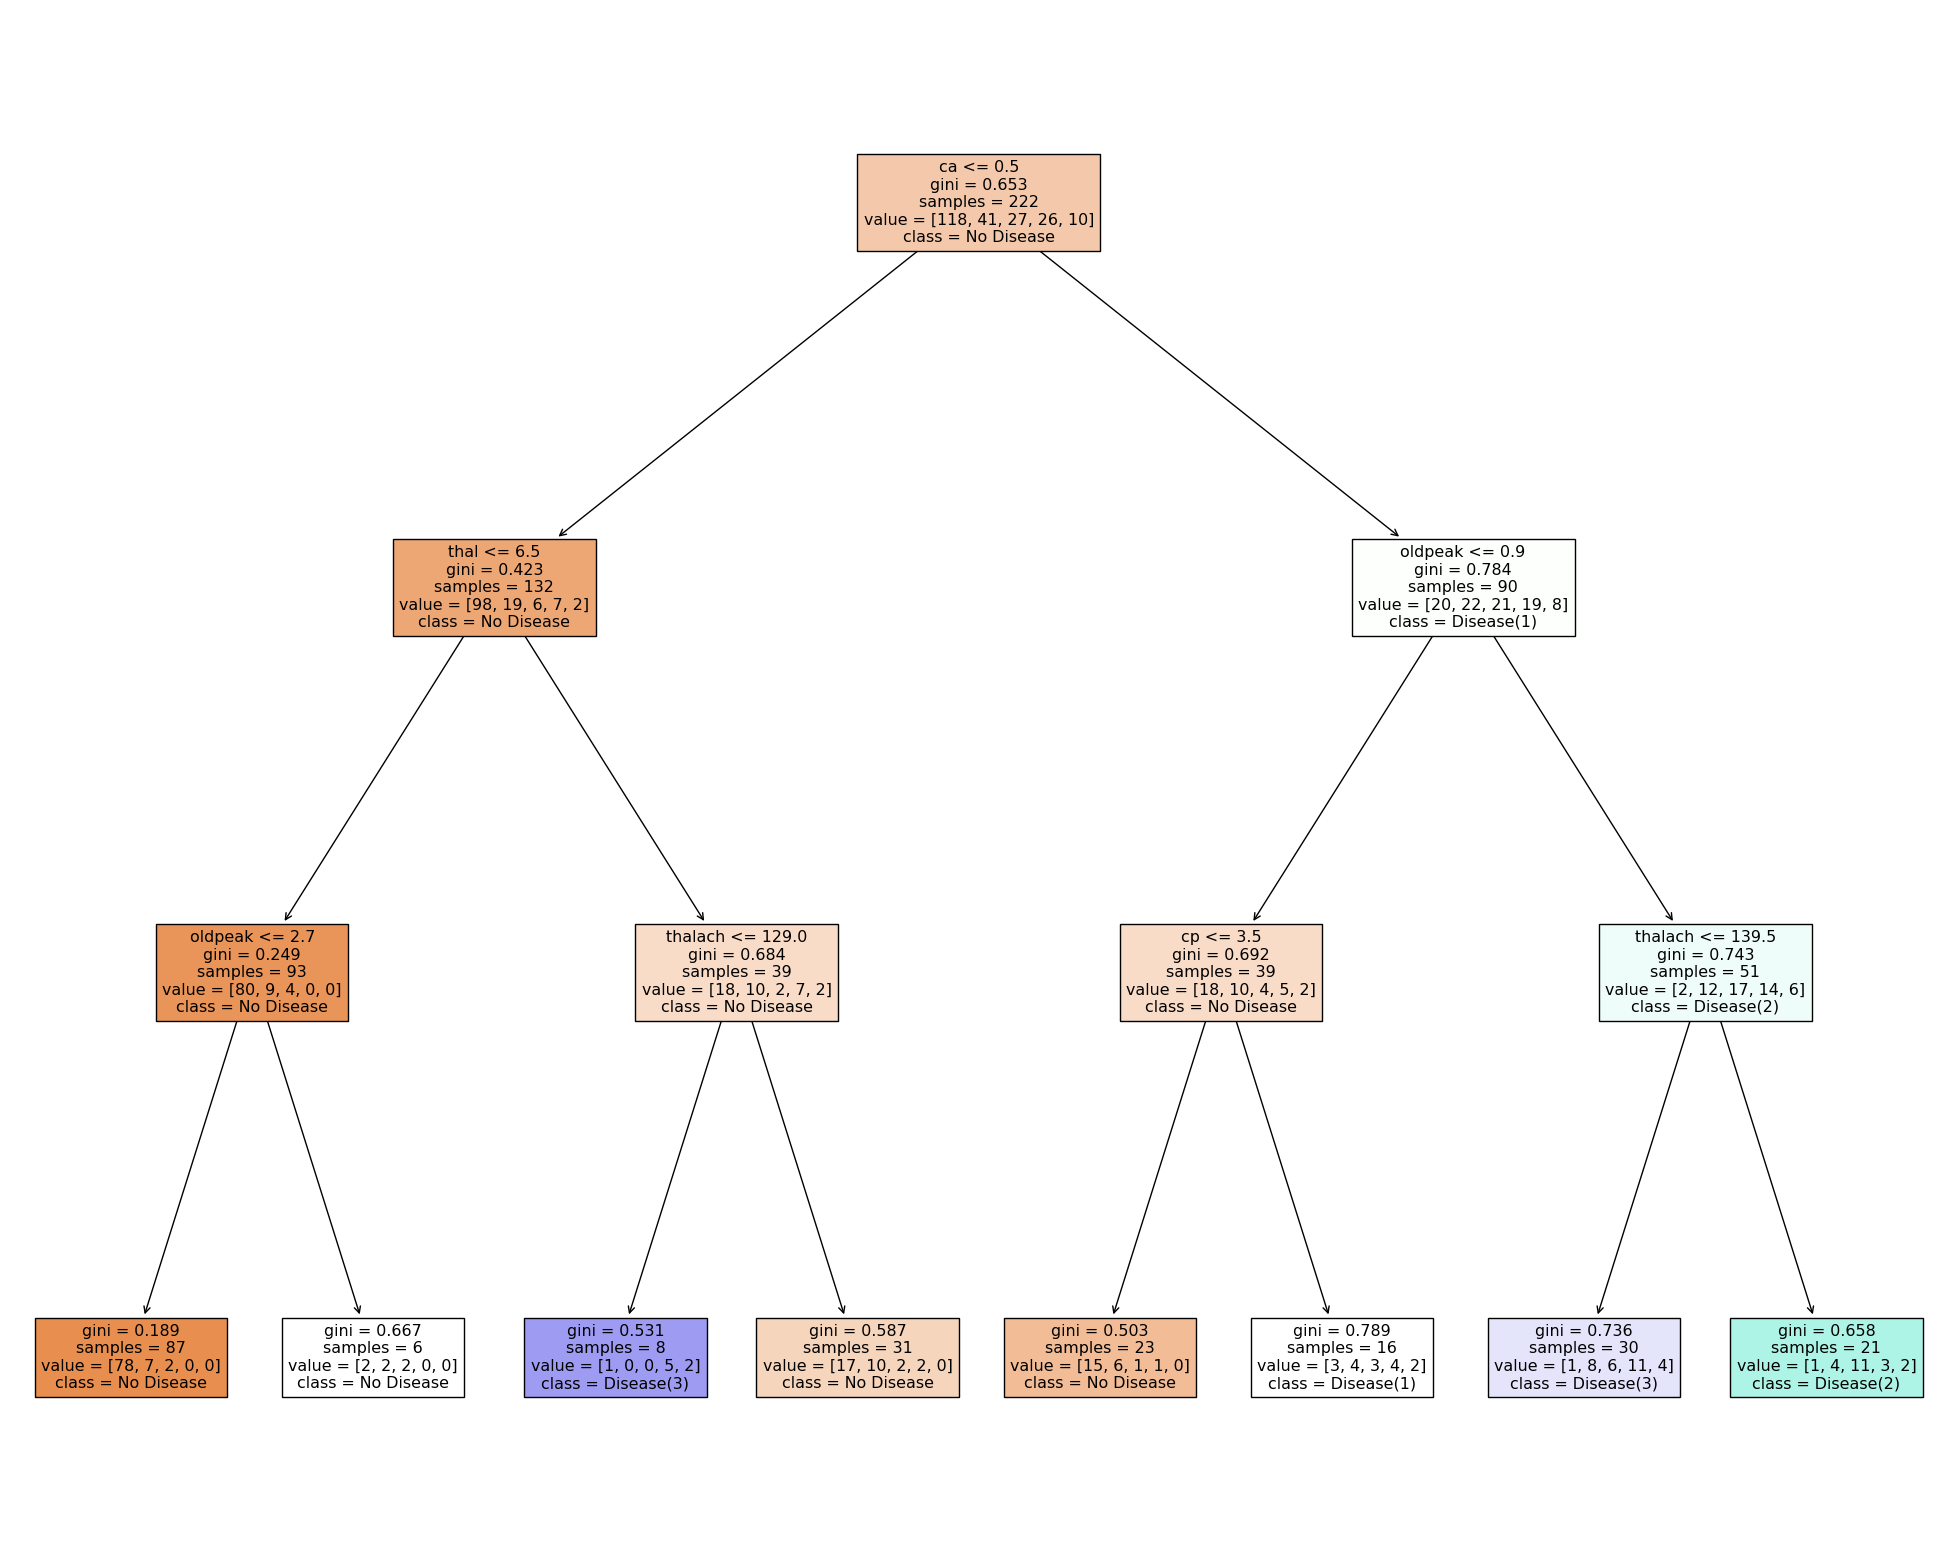

In [113]:
text_representation = tree.export_text(dt)
print(text_representation)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt,
                   feature_names=X.columns,
                   class_names=['No Disease', "Disease(1)", "Disease(2)", "Disease(3)", "Disease(4)"],
                   filled=True)

### Slučajna šuma

In [114]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print(y_pred_rf)

[0 0 0 4 0 0 0 1 2 0 0 0 0 1 0 0 0 0 3 0 3 1 2 0 3 0 3 0 0 0 0 0 3 0 0 0 2
 0 4 1 0 2 3 0 0 0 0 4 0 0 0 4 0 0 2 3 0 0 4 2 0 0 0 0 0 0 4 0 2 2 1 4 3 0
 2]


##### LIME

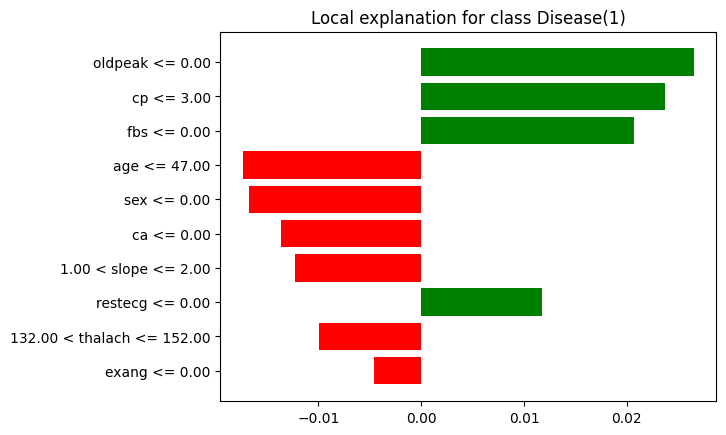

In [115]:
explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names = X.columns,
                                 class_names = ['No Disease','Disease(1)','Disease(2)','Disease(3)','Disease(4)'], 
                                 mode = 'classification')

explanation = explainer.explain_instance(
    data_row=X_test.iloc[0].values,
    predict_fn=lambda x: rf.predict_proba(pd.DataFrame(x, columns=X_train.columns)) 
)

explanation.show_in_notebook(show_table=True, show_all=False)

fig = explanation.as_pyplot_figure()
plt.show()


##### Shapley values

Variable Importance Plot - Global Interpretation


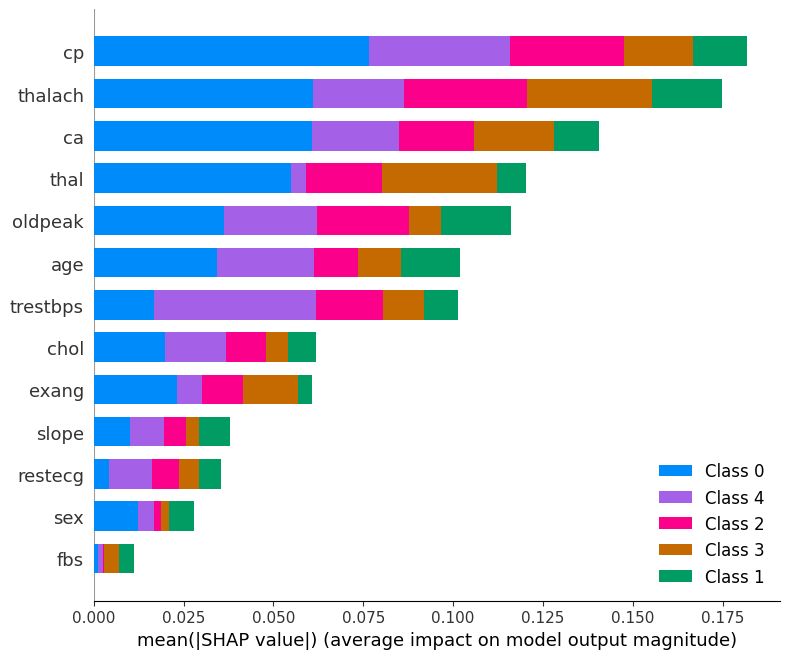

In [116]:
shap.initjs()
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

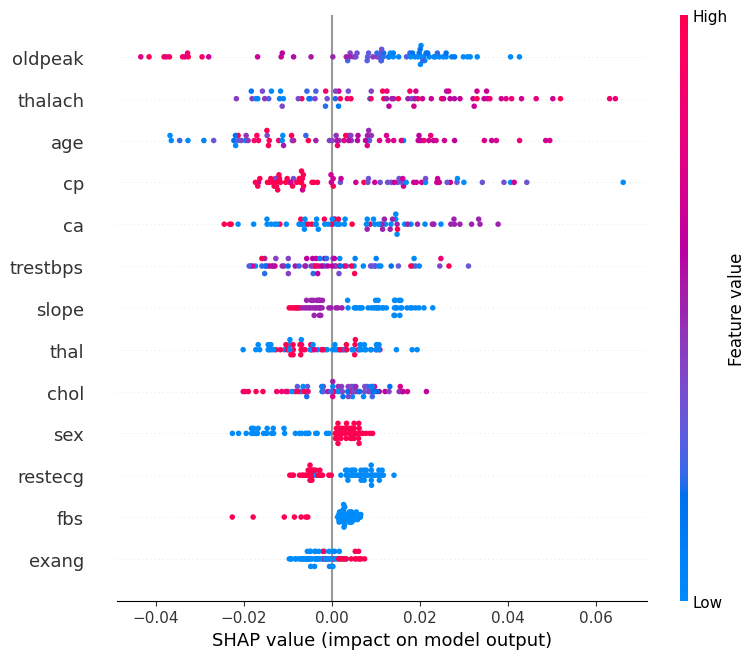

In [117]:
shap.summary_plot(shap_values[1], X_test)

In [118]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test.iloc[0])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0])

### Evaulacija

##### Stablo odluke

In [119]:
print("Accuracy:", accuracy_score(y_test, y_pred_dl85))
print("Classification Report:\n", classification_report(y_test, y_pred_dl85, zero_division = 0))
print(confusion_matrix(y_test, y_pred_dl85))

Accuracy: 0.6266666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.95      0.84        42
           1       0.40      0.15      0.22        13
           2       0.33      0.12      0.18         8
           3       0.29      0.44      0.35         9
           4       0.00      0.00      0.00         3

    accuracy                           0.63        75
   macro avg       0.35      0.34      0.32        75
weighted avg       0.56      0.63      0.57        75

[[40  0  1  1  0]
 [ 6  2  1  4  0]
 [ 2  1  1  4  0]
 [ 3  2  0  4  0]
 [ 2  0  0  1  0]]


In [120]:
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt, zero_division = 0))
print(confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.5866666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81        42
           1       0.33      0.15      0.21        13
           2       0.18      0.25      0.21         8
           3       0.36      0.44      0.40         9
           4       0.00      0.00      0.00         3

    accuracy                           0.59        75
   macro avg       0.33      0.34      0.33        75
weighted avg       0.55      0.59      0.56        75

[[36  1  4  1  0]
 [ 7  2  1  3  0]
 [ 2  2  2  2  0]
 [ 1  1  3  4  0]
 [ 1  0  1  1  0]]


##### Slučajna šuma

In [121]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, zero_division = 0))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy: 0.5866666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89        42
           1       0.20      0.08      0.11        13
           2       0.22      0.25      0.24         8
           3       0.25      0.22      0.24         9
           4       0.00      0.00      0.00         3

    accuracy                           0.59        75
   macro avg       0.30      0.30      0.29        75
weighted avg       0.56      0.59      0.57        75

[[39  2  1  0  0]
 [ 6  1  2  2  2]
 [ 0  1  2  3  2]
 [ 0  0  4  2  3]
 [ 1  1  0  1  0]]
